## Import related package

In [1]:
import random
## Import tensorflow package for modeling
import torch
from torch.autograd import Variable
import torch.optim as optim

## Data processing
import pandas as pd
import numpy as np

## Min-max normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Plot the graph
import matplotlib.pyplot as plt
%matplotlib inline

## Initializing module
from sklearn.linear_model import LinearRegression
np.set_printoptions(suppress=True)

## Copy module
import copy

## Used to calculate the training time
import time
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta

## Set the GUP environment
import os
import sys

from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

In [2]:
## Set up the display
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True, threshold=np.inf)

In [3]:
## Set seed for random function
random.seed(168)

# Data preparation

In [4]:
## 讀入原始資料
demand = pd.read_csv("demand.csv")

In [5]:
## 區分出 x 與 y 資料
demand_x = demand.iloc[:,:-1]
demand_y = pd.DataFrame(demand.iloc[:,-1])

In [6]:
## 排除前 6 個月需求皆為 0 的資料
demand_y = demand_y[~((demand_x["t-4"]==0) & (demand_x["t-3"]==0) & (demand_x["t-2"]==0) & (demand_x["t-1"]==0) & (demand_x["t"]==0) & (demand_x["t+1"]==0))]
demand_x = demand_x[~((demand_x["t-4"]==0) & (demand_x["t-3"]==0) & (demand_x["t-2"]==0) & (demand_x["t-1"]==0) & (demand_x["t"]==0) & (demand_x["t+1"]==0))]

## 重新排序
demand_x.reset_index(drop=True, inplace=True)
demand_y.reset_index(drop=True, inplace=True)

In [7]:
##Add new column "Number" to demand_y
demand_y.insert(0, "Number", demand_x["Number"])

In [8]:
## Set up the label encoder 
labelencoder = LabelEncoder()
demand_x_encode = copy.deepcopy(demand_x)
demand_y_encode = copy.deepcopy(demand_y)

In [9]:
## Encode the material number
demand_x_encode["Number"]=labelencoder.fit_transform(demand_x_encode["Number"])
demand_y_encode["Number"]=labelencoder.transform(demand_y_encode["Number"])

## 從 1 開始編碼
demand_x_encode["Number"] = demand_x_encode["Number"]+1
demand_y_encode["Number"] = demand_y_encode["Number"]+1

In [10]:
## Print out each meaning of code
material_num = [i for i in range(len(demand_x_encode["Number"].unique()))]
print(labelencoder.inverse_transform(material_num))

['CC1101040' 'CC1101050' 'CC110105002300' 'CC1101060' 'CC110106001800'
 'CC110106004900' 'CC1101080' 'CC110108002300' 'CC110108002800'
 'CC110108004300' 'CC110108004500' 'CC110108004700' 'CC1101100'
 'CC1102035' 'CC1102070' 'CC1102080' 'CC110208001800' 'CC110208002500'
 'CC110208003600' 'CC1102090' 'CC1102100' 'CC110210002800' 'CC1102120'
 'CC1102150' 'CC1102160' 'CC1102200' 'CC1102300' 'CC1102400']


In [11]:
def data_preparation(demand_x_encode, demand_y_encode):
    
    numbers = [number for number in demand_x_encode["Number"].unique()]

    x_train, y_train, x_test, y_test = np.array([]), np.array([]), np.array([]), np.array([])

    for i in range(len(numbers)):

        target_x = demand_x_encode[demand_x_encode["Number"]== numbers[i]]
        target_y = demand_y_encode[demand_y_encode["Number"]== numbers[i]]

        target_x.reset_index(inplace=True, drop=True)
        target_y.reset_index(inplace=True, drop=True)

        target_x_volume = np.array(target_x)
        target_y_volume = np.array(target_y["t+2"])


        ## Handling outlier
        #選定幾倍 IQR 值以外去除
        n=0

        #IQR = Q3-Q1
        IQR = np.percentile(target_y_volume,75) - np.percentile(target_y_volume,25)

        #outlier = Q3 + n*IQR 
        upper = np.percentile(target_y_volume,75)+n*IQR
        lower = np.percentile(target_y_volume,25)-n*IQR

        #outlier = Q3 + n*IQR 
        target_x_volume = target_x_volume[np.where(target_y_volume <= upper)[0]]
        target_y_volume = target_y_volume[target_y_volume <= upper]

        #outlier = Q1 - n*IQR 
        target_x_volume = target_x_volume[np.where(target_y_volume >= lower)[0]]
        target_y_volume = target_y_volume[target_y_volume >= lower]


        x_train = np.append(x_train, target_x_volume[:int(target_x_volume.shape[0]*0.8)])
        y_train = np.append(y_train, target_y_volume[:int(target_x_volume.shape[0]*0.8)])

        x_test = np.append(x_test, target_x_volume[int(target_x_volume.shape[0]*0.8):])
        y_test = np.append(y_test, target_y_volume[int(target_x_volume.shape[0]*0.8):])

    x_train = x_train.reshape(-1, demand_x_encode.shape[1])
    x_test = x_test.reshape(-1, demand_x_encode.shape[1])

    zip_list = list(zip(x_train.tolist(), y_train.tolist()))
    random.shuffle(zip_list)
    demand_x_shuffle, demand_y_shuffle = zip(*zip_list)
    x_train, y_train = np.array(demand_x_shuffle), np.array(demand_y_shuffle)

    return (x_train, y_train, x_test, y_test)

# Modeling

### Calculate performance measurements

In [12]:
def accuracy_cacl(pred_value, actual_value):
    
    performance = []

    performance.append(torch.mean(torch.abs(pred_value - actual_value)))
    performance.append(torch.sqrt(torch.mean((pred_value - actual_value)**2)))
    
    for i in range(500, 600, 100):
        correct_times = torch.nonzero(torch.abs(pred_value - actual_value) <= i)
        accuracy = correct_times.shape[0]/pred_value.shape[0]
        performance.append(accuracy)
    
    performance.append(torch.std(torch.abs(pred_value - actual_value)))
    
    return performance

### Plot the forecasted value

In [13]:
def plot_result(name, pred_value, actual_value):
    
    fig, ax = plt.subplots(1,figsize=(20,10), sharex=True, sharey=True)
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.plot(pred_value, label="Forecasted price")
    ax.plot(actual_value, label="Actual")
    ax.set_title("Forecasted performance")
    ax.legend()

    fig.suptitle("In the %s process"%(name))
    fig.tight_layout()

In [14]:
def validation(date, network, nb_step4, nb_step6_1, nb_step6_2, x_train, y_train, x_test, y_test, material_number):

    ## 取得使用時間以及預測時間點
    current_date = date.apply(lambda x: x + relativedelta(months=4)) 
    forecast_date = date.apply(lambda x: x + relativedelta(months=6)) 
    
    ## forward operation
    yo, loss= network.forward()
    
    ## forecast the training data
    pre_train = yo.data.cpu()
    true_train = network.y.data.cpu()
    pred_value_train = torch.FloatTensor(pre_train)
    actual_value_train = torch.FloatTensor(true_train)
    
    ## calculate the performance of training data
    accuracy_train = accuracy_cacl(pred_value_train,actual_value_train)

    ## forecast the testing data
    pred_value_test = torch.FloatTensor(network.forecast(x_test).data.cpu())
    
    ## calculate the performance of testing data
    accuracy_test = accuracy_cacl(pred_value_test, y_test)
    
    ## print out some information
    for i in range(pred_value_test.shape[0]):

        print("Material: %s" %(material_number[i]))
        print("Beginning of this month: %s" %(datetime.date(current_date[i])))
        print("The forecasted demand for the coming second month(%s): %.2f Kg" %(datetime.date(forecast_date[i]), pred_value_test[i]))
        print("<<Performance measurement in training stage>>")
        print("Mean of error: %.2f" %(accuracy_train[0]))
        print("Std of error: %.2f" %(accuracy_train[3]))
        print("The accuracy(500): %.2f%%" %(accuracy_train[2]*100))
        print("-"*120)
    
    predict_value = pd.DataFrame({
    
        "Actual":y_test.reshape((-1,)),
        "SS": torch.reshape(pred_value_test,(-1,)).numpy()
    })
    
    predict_value.to_csv("pre_result.csv", index=False)
    plot_result("training",pred_value_train, actual_value_train)
    plot_result("inferencing",pred_value_test, y_test)
    
    pre_LDSS = network.forecast(x_test).data.cpu()

### Network class

In [15]:
class Network(torch.nn.Module):
    
    def __init__(self, nb_neuro, x_train_scaled, y_train_scaled):
        
        super(Network, self).__init__()
        self.linear1 = torch.nn.Linear(x_train_scaled.shape[1], nb_neuro).cuda()
        self.linear2 = torch.nn.Linear(nb_neuro, 1).cuda()
        
        
        # Stop criteria - threshold
        self.threshold_for_error = 0.12
        self.threshold_for_lr = 1e-4
        
        # Input data 
        self.x = torch.FloatTensor(x_train_scaled).cuda()
        self.y = torch.FloatTensor(y_train_scaled).cuda()
        
        # Learning rate
        self.learning_rate = 1e-3
        
        # Whether the network is acceptable, default as False
        self.acceptable = False
        
        # Some record for experiment
        self.nb_node_pruned = 0
        self.nb_node_acceptable=torch.IntTensor([nb_neuro])
        
        self.limit = nb_neuro
        
    ## Forecast the test data
    def forecast(self, x_test):
    
        x_test = torch.FloatTensor(x_test).cuda()
        activation_value = self.linear1(x_test).clamp(min=0)
        forecast_value = self.linear2(activation_value)
       
        return forecast_value

    ## Reset the x and y data
    def setData(self, x_train_scaled, y_train_scaled):
        self.x = torch.FloatTensor(x_train_scaled).cuda()
        self.y = torch.FloatTensor(y_train_scaled).cuda()
    
    ## Add the new data to the x and y data
    def addData(self, new_x_train, new_y_train):

        self.x = torch.cat([self.x, new_x_train.reshape(1,-1).cuda()],0)
        self.y = torch.cat([self.y, new_y_train.reshape(-1,1).cuda()],0)
    
    ## forward operation
    def forward(self, reg_strength=0):
       
        y1 = self.linear1(self.x).clamp(min=0)
        yo = self.linear2(y1)

        # performance measure
        param_val= torch.sum(torch.pow(self.linear2.bias.data,2))+torch.sum(torch.pow(self.linear2.weight.data,2))+torch.sum(torch.pow(self.linear1.bias.data,2))+torch.sum(torch.pow(self.linear1.weight.data,2))
        reg_term= reg_strength/((self.linear2.bias.data.shape[0]*(self.linear2.weight.data.shape[1]+1)) +(self.linear1.bias.data.shape[0]*(self.linear1.weight.data.shape[1]+1)))*param_val
        loss = torch.nn.functional.mse_loss(yo,self.y)+reg_term
        loss = loss.cuda()
        return(yo, loss)

    # backward operation
    def backward_Adadelta(self,loss):    

        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Initializing module (Check)

In [16]:
def initializing(network, initial_x, initial_y):

    ## Find each minimum output value y
    min_y = torch.min(initial_y, axis=0)
    
    ## Subtract min_y from each y
    res_y = initial_y-min_y.values
    
    ## Use linear regression to find the initial W1,b1,Wo,bo
    reg = LinearRegression().fit(initial_x, res_y)
    
    ## Set up the initial parameter of the network
    network.linear1.weight = torch.nn.Parameter(torch.FloatTensor(reg.coef_).cuda())
    network.linear1.bias = torch.nn.Parameter(torch.FloatTensor(reg.intercept_).cuda())
    network.linear2.weight=torch.nn.Parameter(torch.FloatTensor([[1]]).cuda())
    network.linear2.bias = torch.nn.Parameter(torch.FloatTensor(min_y.values).cuda())
    
    ## Set up the acceptable of the initial network as True
    network.acceptable =True

### Selecting module (Check)

In [17]:
def selecting(network, x_train_scaled, y_train_scaled):
    
    loss = []
    temp_network = copy.deepcopy(network)
    
    ## Put each data into network to calculate the loss value
    for i in range(x_train_scaled.shape[0]):
        temp_network.setData(x_train_scaled[i].reshape(1,-1), y_train_scaled[i].reshape(-1,1))
        loss.append((temp_network.forward()[1].item(),i))

    ## Sort the data according to the loss value from smallest to largest, and save the data index in sorted_index
    sorted_index = [sorted_data[1] for sorted_data in sorted(loss, key = lambda x:x[0])]
    
    return sorted_index

### Matching

In [18]:
def matching(network):

    times_enlarge=0
    times_shrink=0
    
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3
    network.acceptable = False
    initial_network = copy.deepcopy(network)

    yo, loss = network.forward()
    
    if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):

        network.acceptable = True
        return(network)
    
    else:
    
        while True:

            yo, loss = network.forward()
            network_pre = copy.deepcopy(network)
            loss_pre = loss
            
            # Backward and check the loss performance of the network with new learning rate
            network.backward_Adadelta(loss)
            yo, loss = network.forward()

            # Confirm whether the loss value of the adjusted network is smaller than the current one
            if loss <= loss_pre and torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
       
                network.acceptable = True
                return(network)

            elif loss <= loss_pre:
                
                times_enlarge+=1
                network.learning_rate *= 1.2

            else:         

                # Identify whether the current learning rate is less than the threshold
                if network.learning_rate <= network.threshold_for_lr:

                    # If true, set the acceptable of the network as false and return it
                    network.acceptable = False
                    return(initial_network)

                # On the contrary, restore w and adjust the learning rate
                else:
                    
                    # Restore the papameter of the network
                    network = copy.deepcopy(network_pre)
                    times_shrink+=1
                    network.learning_rate *= 0.7

### Matching for reorganizing

In [19]:
def matching_for_reorganizing(network):

    times_enlarge=0
    times_shrink=0
    
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3
    network.acceptable = False
    initial_network = copy.deepcopy(network)
    yo, loss = network.forward()
    
    if torch.all(torch.abs(yo-network.y) < network.threshold_for_error):

        network.acceptable = True
        return(network)
    
    else:
        
        for i in range(500):
            
            yo, loss = network.forward()
            network_pre = copy.deepcopy(network)
            loss_pre = loss

            # Backward and check the loss performance of the network with new learning rate
            network.backward_Adadelta(loss)
            yo, loss = network.forward()

            # Confirm whether the loss value of the adjusted network is smaller than the current one
            if loss <= loss_pre and torch.all(torch.abs(yo-network.y) < network.threshold_for_error):

                # If true, multiply the learning rate by 1.2
                network.acceptable = True
                return(network)

            elif loss <= loss_pre:
                
                times_enlarge+=1
                network.learning_rate *= 1.2


            else:         

                # Identify whether the current learning rate is less than the threshold
                if network.learning_rate <= network.threshold_for_lr:

                    # If true, set the acceptable of the network as false and return it
                    network.acceptable = False
                    return(initial_network)

                # On the contrary, restore w and adjust the learning rate
                else:

                    # Restore the papameter of the network
                    network = copy.deepcopy(network_pre)
                    times_shrink+=1
                    network.learning_rate *= 0.7
                
        network.acceptable = False

        return(initial_network)

## Cramming module (Check)

In [20]:
def cramming(network):
    
    torch.manual_seed(168)

    ## Find unsatisfied data:K
    yo, loss = network.forward()
    undesired_index = torch.nonzero(torch.abs(yo-network.y) > network.threshold_for_error+0.1, as_tuple =False)

    
    if undesired_index.shape[0] == 1:
        
        # Unsatisfied situation
        ## Find the index of the unsatisfied data
        k_data_num = undesired_index[0][0]

        undesired_data = torch.reshape(network.x[k_data_num,:], [1,-1])

        ## Remove the data that does not meet the error term
        remain_tensor = network.x[:k_data_num,:]

        ## Use the random method to find out the gamma and zeta
        while True:

            ## Find m-vector gamma: r
            ## Use the random method to generate the gamma that can make the conditions met
            gamma = torch.rand(size=[1,network.x.shape[1]]).cuda()
            subtract_undesired_data = torch.sub(remain_tensor, undesired_data)
            matmul_value = torch.mm(gamma,torch.t(subtract_undesired_data))

            if torch.all(matmul_value != 0):
                break

        while True:

            ## Find the tiny value: zeta
            ## Use the random method to generate the zeta that can make the conditions met
            zeta = torch.rand(size=[1]).cuda()
            if torch.all(torch.mul(torch.add(zeta,matmul_value),torch.sub(zeta,matmul_value))<0):
                break

       

        k_l = undesired_index[0][1]
        
        ## The weight of input layer to hidden layer I
        w10 = gamma
        w11 = gamma
        w12 = gamma

        W1_new = torch.cat([w10,w11,w12],0)
        

        ## The bias of input layer to hidden layer I
        matual_value = torch.mm(gamma,torch.t(undesired_data))
       
        
        b10 = torch.sub(zeta,matual_value)
        b11 = -1*matual_value
        b12 = torch.sub(-1*zeta,matual_value)

        b1_new = torch.reshape(torch.cat([b10,b11,b12],0),[3])

        gap = network.y[k_data_num, k_l]-yo[k_data_num, k_l]

        
        wo0_value = gap/zeta
        wo1_value = (-2*gap)/zeta
        wo2_value = gap/zeta

        Wo_new = torch.reshape(torch.cat([wo0_value,wo1_value,wo2_value],0),[1,-1])

        ## Add new neuroes to the network
        network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight.data, W1_new]))
        network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias.data, b1_new]))
        network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight.data, Wo_new],1))


        yo, loss = network.forward()
        
        ## Determine if cramming is successful and print out the corresponding information
        if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
            network.acceptable = True 
    
    else:
        print("條件不合，不能Cramming")

### Regularizing module (Check)

In [21]:
def regularizing(network):

    ## Record the number of executions
    times_enlarge = 0
    times_shrink = 0
    
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3

    ## Set epoch to 100
    for i in range(100):

        ## Store the parameter of the network
        network_pre = copy.deepcopy(network)
        yo, loss = network.forward(1e-3)
        loss_pre = loss

        
        ## Backward operation to obtain w'
        network.backward_Adadelta(loss)
        yo, loss = network.forward(1e-3)

        
         # Confirm whether the adjusted loss value is smaller than the current one
        if loss <= loss_pre:
            
            ## Identify that all forecast value has met the error term
            if torch.all(torch.abs(yo-network.y) < network.threshold_for_error):
                
                ## If true, multiply the learning rate by 1.2
                network.learning_rate *= 1.2
                times_enlarge += 1


            else:

                ## Else, restore w and end the process
                network = copy.deepcopy(network_pre)
                return(network)

        # If the adjusted loss value is not smaller than the current one
        else:

            ## If the learning rate is greater than the threshold for learning rate
            if network.learning_rate > network.threshold_for_lr:
                
                ## Restore the w and multiply the learning rate by 0.7
                network = copy.deepcopy(network_pre)
                network.learning_rate *= 0.7
                times_shrink += 1

                
             ## If the learning rate is smaller than the threshold for learning rate
            else:
                
                ## Restore the w
                network = copy.deepcopy(network_pre)
                return(network)

    return(network)

### Reorganizing module (Check)

In [22]:
def reorganizing(network):
    
    limit = 1
    if network.linear1.bias.shape[0] <= limit:
        network = regularizing(network)
        return(network)
    
    else:
        
        ## Set up the k = 1, and p = the number of hidden node
        k = 1
        p = network.linear1.weight.data.shape[0]

        while True:

            ## If k > p, end of Process
            if k > p or p<=limit:

                return(network)

            ## Else, Process is ongoing
            else:

                ## Using the regularizing module to adjust the network
                network = regularizing(network)

                ## Store the network and w
                network_pre = copy.deepcopy(network)

                ## Set up the acceptable of the network as false
                network.acceptable = False
                
            
                ## Ignore the K hidden node
                network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight[:k-1],network.linear1.weight[k:]],0))
                network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias[:k-1],network.linear1.bias[k:]]))
                network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight[:,:k-1],network.linear2.weight[:,k:]],1))

                
                ## Using the matching module to adjust the network
                network = matching_for_reorganizing(network)


                ## If the resulting network is acceptable, this means that the k hidden node can be removed
                if network.acceptable:

                    network.nb_node_pruned += 1
                    ## p--
                    p-=1

                ## Else, it means that the k hidden node cannot be removed
                else:

                    ## Restore the network and w
                    network = copy.deepcopy(network_pre)
#                     print("Cannot drop out the nero number: %d / %d" %(k, p))

                    ## k++
                    k+=1

## The training data & testing data

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Material: CC110108002300
Beginning of this month: 2018-11-01
The forecasted demand for the coming second month(2019-01-01): 395.71 Kg
<<Performance measurement in training stage>>
Mean of error: 290.44
Std of error: 186.45
The accuracy(500): 90.11%
------------------------------------------------------------------------------------------------------------------------
Material: CC110108002300
Beginning of this month: 2019-02-01
The forecasted demand for the coming second month(2019-04-01): 395.71 Kg
<<Performance measurement in training stage>>
Mean of error: 290.44
Std of error: 186.45
The accuracy(500): 90.11%
------------------------------------------------------------------------------------------------------------------------
Material: CC110108002300
Beginning of this month: 2019-03-01
The forecasted demand for the coming second month(2019-05-01): 395.71 Kg
<<Performance measurement in training stage>>
Mean of error: 290.44
Std of error: 186.45
The accuracy(500): 90.11%
-----------

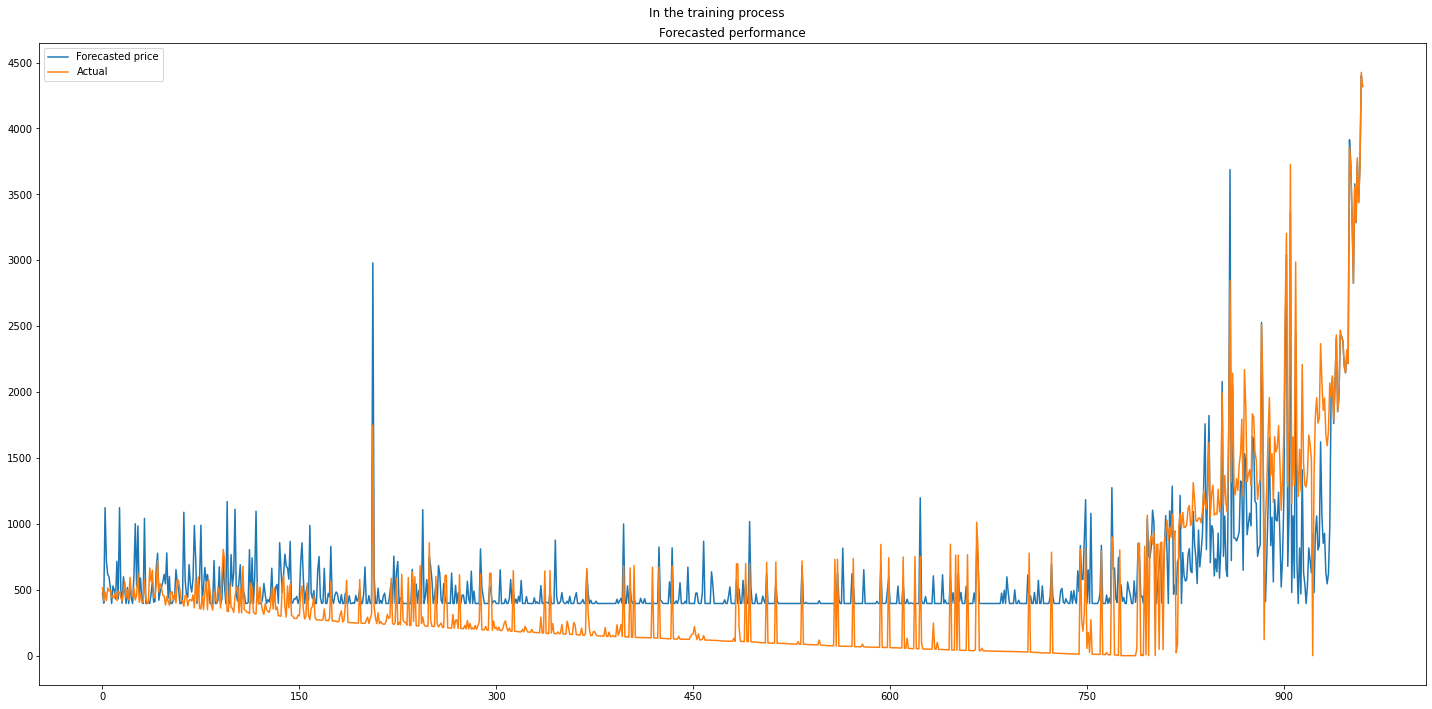

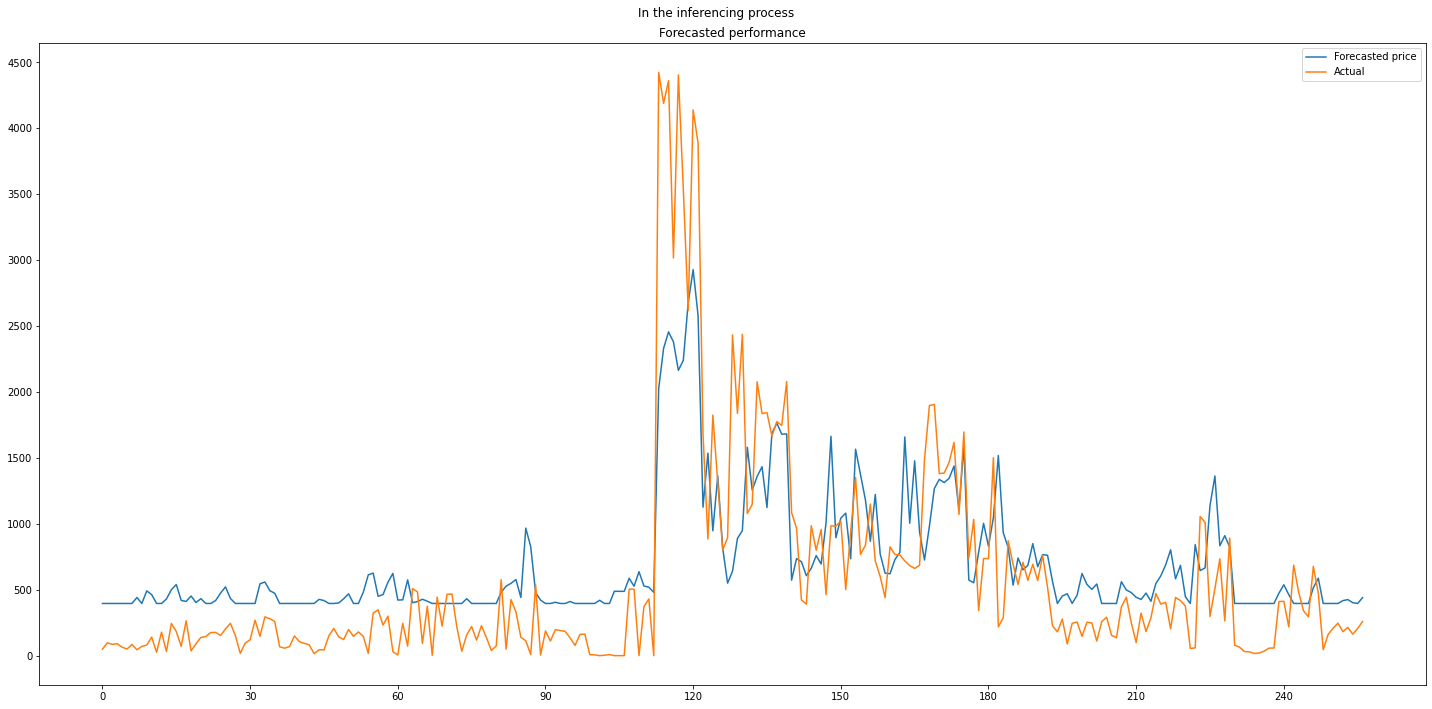

In [23]:
## 取得對應訓練與測試資料
x_train, y_train, x_test, y_test = data_preparation(demand_x_encode, demand_y_encode)

## 取得時間
x_train = np.delete(x_train, 2, axis=1)
x_train = x_train.astype(np.float64)

date = x_test[:,2]

x_test = np.delete(x_test, 2, axis=1)
x_test = x_test.astype(np.float64)

date = pd.Series(date)
date = pd.to_datetime(date, format="%Y/%m/%d")

## 取得料號
material_number = x_test[:,0]-1
material_number = material_number.astype(np.int64)
material_number = labelencoder.inverse_transform(material_number)

## 變為Tensor型態
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train).reshape(-1,1)

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test).reshape(-1,1)


threshold_for_error = 1100


start = time.time()

## Record the number of each step
nb_step4 = 0
nb_step6_1 = 0
nb_step6_2 = 0


lower = torch.mean(y_train)-0.1*torch.std(y_train)
upper = torch.mean(y_train)+0.1*torch.std(y_train)
nonoutlier_index = torch.nonzero((y_train[:,0]>lower)&(y_train[:,0]<upper), as_tuple =False).reshape([-1])

initial_x = x_train[nonoutlier_index[:x_train.shape[1]+1]]
initial_y = y_train[nonoutlier_index[:x_train.shape[1]+1]]

x_train = x_train[x_train.shape[1]:]
y_train = y_train[x_train.shape[1]:]


network = Network(1,initial_x,initial_y)

network.nb_node_acceptable = torch.IntTensor([1 for _ in range(initial_x.shape[0])])
network.threshold_for_error = threshold_for_error

initializing(network, initial_x, initial_y)
nb_step4 += initial_x.shape[0]


remainder = x_train.shape[0]


for i in range(remainder):
# for i in range(10):
    sorted_index = selecting(network, x_train, y_train)


    ## Add new data for training
      
    network.addData(x_train[sorted_index[0]], y_train[sorted_index[0]])
    x_train = np.delete(x_train, sorted_index[0], 0)
    y_train = np.delete(y_train, sorted_index[0], 0)

    yo,loss = network.forward()

    pre_network = copy.deepcopy(network)

    if not torch.all(torch.abs(network.y-yo)<=network.threshold_for_error):
 
        network.acceptable = False
        network = matching(network)


        yo,loss = network.forward()


        if network.acceptable == False:

            network = copy.deepcopy(pre_network)
            network.acceptable = False
            cramming(network)

#             if network.acceptable == False:
#                 sys.exit("Cramming failed")  

            yo,loss = network.forward()
            network.threshold_for_error = torch.max(torch.FloatTensor([threshold_for_error,torch.max(torch.abs(network.y-yo))]))
            nb_step6_2 += 1

        else:
            nb_step6_1 += 1

    else:
        nb_step4 += 1

    network = reorganizing(network)
    yo,loss = network.forward()
    network.nb_node_acceptable = torch.cat([network.nb_node_acceptable, torch.IntTensor([network.linear1.bias.data.shape[0]])],0)



# Print out information 
validation(date, network, nb_step4, nb_step6_1, nb_step6_2, x_train, y_train,x_test, y_test,material_number)

end = time.time()
print("總計時間(s)", end-start)

## original Back propagation learning algorithm (BP)

In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Flatten, Input

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

In [25]:
pre_result = pd.read_csv("pre_result.csv")

In [26]:
x_train, y_train, x_test, y_test = data_preparation(demand_x_encode, demand_y_encode)
x_train = np.delete(x_train, 2, axis=1)
x_train = x_train.astype(np.float64)
x_test = np.delete(x_test, 2, axis=1)
x_test = x_test.astype(np.float64)

In [27]:
def buildTwoLayerNN(input_shape):

    keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(units=40, activation ="relu", input_shape=(input_shape,)))
    model.add(Dense(units=1)) 

    model.compile(optimizer="Adam", loss="mean_squared_error")

    return model

In [28]:
input_shape = x_train.shape[1]
model = buildTwoLayerNN(input_shape)

In [29]:
model.fit(x_train, y_train, verbose=0)

In [30]:
pre_result["ANN"] = model.predict(x_test)

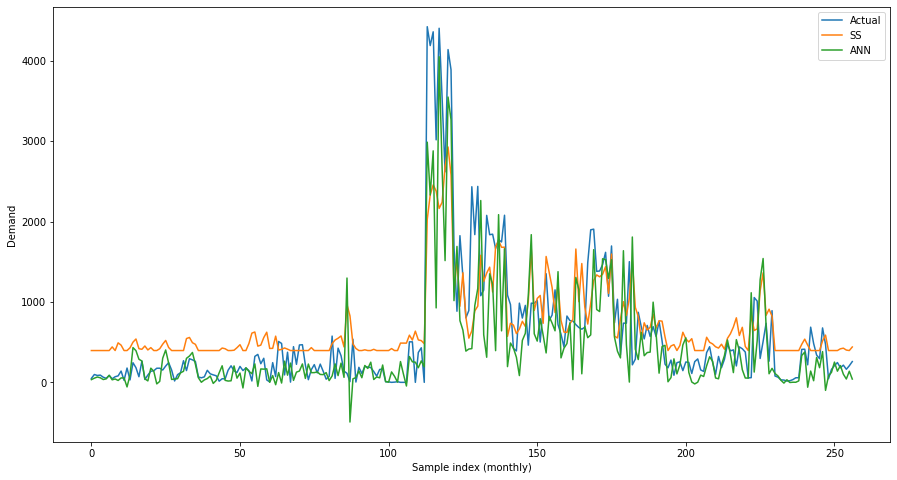

In [31]:
plt.figure(figsize=(15,8))
for i in range(pre_result.shape[1]):
    plt.plot(pre_result.iloc[:,i], label=pre_result.columns[i])

plt.legend()
plt.xlabel("Sample index (monthly)")
plt.ylabel("Demand")
plt.savefig('comparison.png')

In [32]:
evaluation_results = pd.DataFrame(columns=["Model","MAE","SD of absolute error","RMSE","Accuracy(500)"])

mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()

for i in range(1,pre_result.shape[1]):
    
    val_mae = mae(pre_result["Actual"], pre_result.iloc[:,i]).numpy()
    
    val_rmse = tf.math.sqrt(mse(pre_result["Actual"], pre_result.iloc[:,i])).numpy()
        
    y_true = pre_result["Actual"]
    y_pred = pre_result.iloc[:,i]

    val_sdae = tf.math.reduce_std(tf.math.abs(y_true - y_pred)).numpy()
    
    total_times = y_true.shape[0]
    correct_times = 0
        
    for _ in range(total_times): 

        correct_times = np.count_nonzero(abs(y_true-y_pred) < 500)

    
    new_result = pd.DataFrame({

        "Model" : [pre_result.columns[i]],
        "MAE" : [val_mae],
        "SD of absolute error": val_sdae,
        "RMSE" : [val_rmse],
        "Accuracy(500)" : [correct_times/total_times]
        
    })

    evaluation_results = evaluation_results.append(new_result, ignore_index=True)

In [33]:
evaluation_results.to_csv("judgement.csv", index=False)